In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
BASISSET = 'sto-3g'
BASISSET = 'def2-tzvp'
import matplotlib as mpl
font = {'family' : 'nomal', 'weight' : 'normal', 'size'   : 14}
mpl.rc('font', **font)

In [2]:
def read_grids():
    return pd.read_pickle('../data-tmp/grids/N2.pkl.gz')
    
def read_data(basisset):
    dfs = []
    for dZ in range(1, 7):
        fn = '../data-tmp/%s/cache-%d.pkl.gz' % (basisset, dZ)
        dfs.append(pd.read_pickle(fn))
    return pd.concat(dfs).reset_index(drop=True).sort_values('mixing')

def read_atom(basisset):
    lookup = {'sto-3g': 'STO-3G', 'def2-tzvp': 'def2-tzvp'}
    ret = pd.read_pickle('../data-tmp/atom-energies.pkl')
    return ret[ret['basis'] == lookup[basisset]]

grids = read_grids()
cache = read_data(BASISSET)
atoms = read_atom(BASISSET)

In [3]:
def integrate():
    ret = []
    for name, group in cache.groupby('dZ bond'.split()):
        rhotilde = np.trapz(group.density.values, group.mixing.values, axis=0)
        grid = grids[grids.bond == group.bond.unique()[0]].iloc[0]

        for atom in range(2):
            contribution = -np.sum(rhotilde * grid.weights / np.linalg.norm(grid.points - grid.coordinates[atom], axis=1))
            ret.append({'bond': group.bond.unique()[0], 'site': atom, 'energy': contribution, 'dZ': group.dZ.unique()[0]})
    return pd.DataFrame(ret)
integrated = integrate()

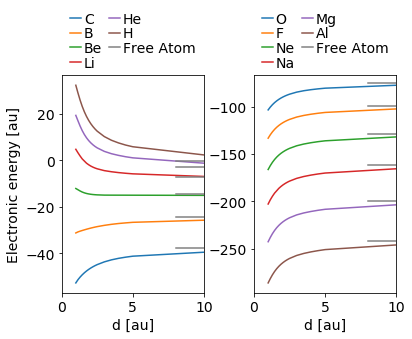

In [55]:
def plot_electronic():
    elements = '_ H He Li Be B C N O F Ne Na Mg Al'.split()
    lookup = {elements.index(_): _ for _ in elements}
    f, axs = plt.subplots(1,2, sharey=False)
    for name, group in integrated.groupby('dZ site'.split()):
        dZ, site = name
        
        # get reference
        s = cache.query('mixing == 0. & dZ == @dZ').copy()
        s['ref'] = (s.energy-s.Enn)/2
        s.sort_values('bond')
        del s['energy']
        group = pd.merge(group, s, how='left', on='bond'.split()).dropna()
        
        if site == 0:
            label = lookup[7-int(dZ)]
            prefactor = -dZ
        else:
            label = lookup[7+int(dZ)]
            prefactor = dZ
        axs[site].plot(group.bond.values, prefactor*group.energy.values + group.ref.values, label=label)
    for Z, value in zip(atoms.Z.values, atoms.energy.values):
        if Z == 7:
            continue
            
        if (abs(Z-7) == 1):
            label ='Free Atom'
        else:
            label = None
        
        axs[int(Z>7)].axhline(value, xmin=0.8, color='grey', label=label)
    
    axs[0].legend(ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.35), labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=0.8, fancybox=False, frameon=False )
    axs[1].legend(ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.35), labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=0.8, fancybox=False, frameon=False )
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 10)
    axs[0].set_ylabel('Electronic energy [au]')
    axs[0].set_xlabel('d [au]')
    axs[1].set_xlabel('d [au]')
    plt.subplots_adjust(wspace=0.35)
    plt.savefig('n2electronic.pdf', bbox_inches='tight')
    #plt.suptitle(BASISSET)
plot_electronic()

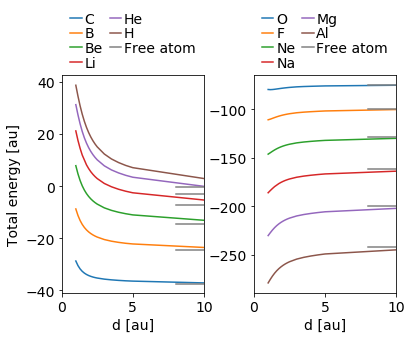

In [58]:
def plot_total():
    elements = '_ H He Li Be B C N O F Ne Na Mg Al'.split()
    lookup = {elements.index(_): _ for _ in elements}
    f, axs = plt.subplots(1,2, sharey=False)
    for name, group in integrated.groupby('dZ site'.split()):
        dZ, site = name
        
        # get reference
        s = cache.query('mixing == 0. & dZ == @dZ').copy()
        s['ref'] = (s.energy-s.Enn)/2
        s.sort_values('bond')
        del s['energy']
        group = pd.merge(group, s, how='left', on='bond'.split()).dropna()
        nuclearshift = ((7*7)-((7+dZ)*(7-dZ)))/group.bond.values / 2
        nucleartarget = ((7+dZ)*(7-dZ))/group.bond.values
        
        if site == 0:
            label = lookup[7-int(dZ)]
            prefactor = -dZ
        else:
            label = lookup[7+int(dZ)]
            prefactor = dZ
        axs[site].plot(group.bond.values, prefactor*group.energy.values + group.ref.values + nucleartarget/2, label=label)
    for Z, value in zip(atoms.Z.values, atoms.energy.values):
        if Z == 7:
            continue
            
        if (abs(Z-7) == 1):
            label ='Free atom'
        else:
            label = None
        
        axs[int(Z>7)].axhline(value, xmin=0.8, color='grey', label=label)
    axs[0].legend(ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.35), labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=0.8, fancybox=False, frameon=False )
    axs[1].legend(ncol=2, loc='upper center',  bbox_to_anchor=(0.5, 1.35), labelspacing=0.05, handletextpad=0.2, columnspacing=0.5, handlelength=0.8, fancybox=False, frameon=False )
    axs[0].set_xlim(0, 10)
    axs[1].set_xlim(0, 10)
    axs[0].set_ylabel('Total energy [au]')
    axs[0].set_xlabel('d [au]')
    axs[1].set_xlabel('d [au]')
    plt.subplots_adjust(wspace=0.35)
    plt.savefig('n2total.pdf', bbox_inches='tight')
    #plt.suptitle(BASISSET)
plot_total()